# 주린이의 주가 예측

In [1]:
import pandas as pd
import numpy as np
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
import FinanceDataReader as fdr
from matplotlib import font_manager, rc
from scipy import stats
import plotly.express as px
import os
from selenium import webdriver
import bs4
%matplotlib inline

In [30]:
# 투자심리선이란 최근 12일 동안 주가가 전일과 대비해서 상승한 일수와 하락한 일수를 계산하여 
# 12일 중 상승 일수가 며칠이었는가에 대한 비율을 나타낸다. 
# 투자심리도가 75% 이상이면 과열상태로 판단하여 매도시점이 되고,
# 반대로 25% 이하일 경우 매입시점이 된다.

In [2]:
# 안전하게 코스피 시가총액 상위 10위 종목만 선정

# 웹브라우저 설정 및 브라우저 팝업
options = webdriver.ChromeOptions()
# driverLoc = "C:/Users/김남덕/Desktop/KOPO/김효관/stddev/addon/chromedriver/chromedriver.exe"
driverLoc = "C:/Users/kopo/Desktop/KND/김효관/addon/chromedriver/chromedriver.exe"
driver = webdriver.Chrome(executable_path=driverLoc, options=options)

# 웹페이지 파싱될때까지 최대 3초 기다림
driver.implicitly_wait(3)

# # 브라우저 열기
targetUrl = "https://finance.naver.com/sise/"
driver.get(targetUrl)

# 페이지 url 및 소스 가져오기
finalUrl = driver.current_url
pgSource = driver.page_source

# BS4로 웹크롤링
bsObj = bs4.BeautifulSoup(pgSource, "html.parser")
findAttr = bsObj.find(name = "table", attrs={"id":"siselist_tab_7"})
findPart = findAttr.find_all(name="a")

# 리스트에 종목 저장
stockNameList = []
for i in range(0, len(findPart)):
    stockNameList.append(findPart[i].text)

In [3]:
stockNameList

['삼성전자',
 'SK하이닉스',
 '카카오',
 'NAVER',
 '삼성전자우',
 'LG화학',
 '삼성바이오로직스',
 '현대차',
 '삼성SDI',
 '셀트리온']

In [4]:
# 종목 코드 찾기
kospi = fdr.StockListing('kospi')

In [5]:
# 추출된 종목 코드를 리스트에 담기
stockCodeList = []
for i in range(len(stockNameList)):
    name = kospi[kospi['Name'] == stockNameList[i]]
    stockCode = name.iloc[0][0]
    stockCodeList.append(stockCode)

In [6]:
stockCodeList

['005930',
 '000660',
 '035720',
 '035420',
 '005935',
 '051910',
 '207940',
 '005380',
 '006400',
 '068270']

In [10]:
# 종료일
endDate = date.today()

# 시작일
beginDate = endDate - timedelta(days=90)

In [21]:
# 지난 3개월 동안의 주식 정보 가져오기
for i in range(len(stockCodeList)):
    stockDataInfo = fdr.DataReader(stockCodeList[i], beginDate, endDate)
#     print(stockDataInfo)

In [48]:
# 주식 데이터 가져오기
def getStockInfo(stockCode, beginDate, endDate):
    if stockCode is None:
        print("주식 코드 오류")
        return None
    stockData = fdr.DataReader(stockCode, beginDate, endDate)
    return pd.DataFrame(stockData)

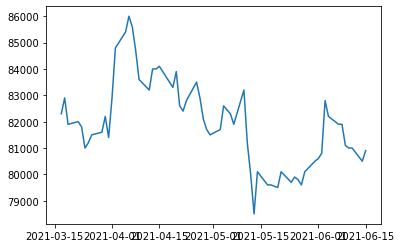

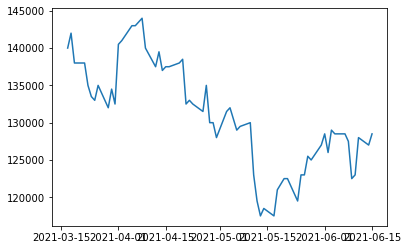

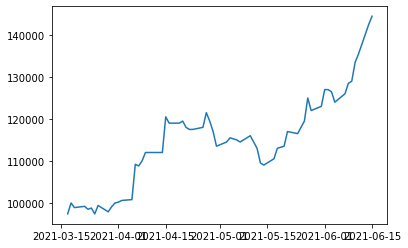

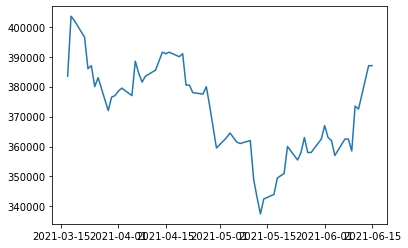

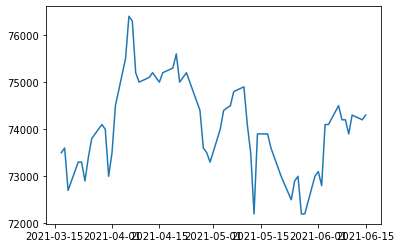

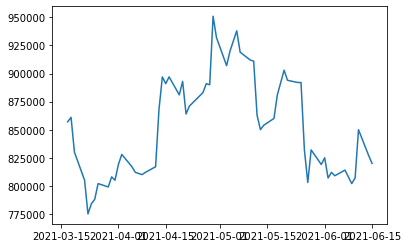

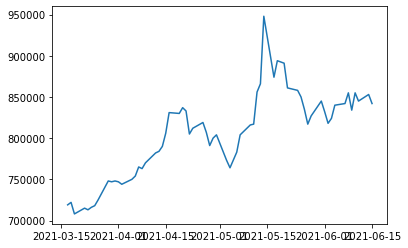

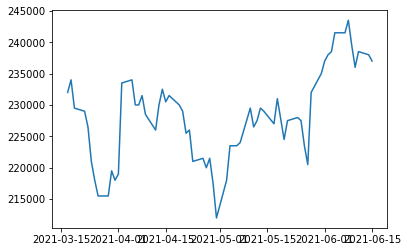

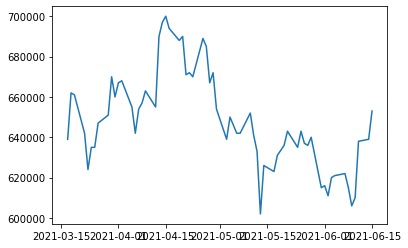

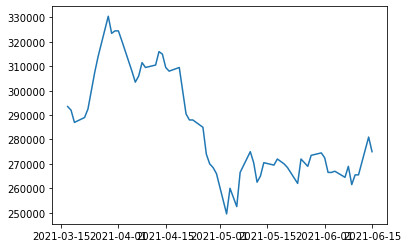

In [65]:
for i in stockCodeList:
    df = getStockInfo(i, beginDate, endDate)
    plt.plot(df["Close"])
    plt.show()

In [17]:
set_period = 12
last_period = 50

def psychoLine(inputData):
    stockDiffList = []
    pLineList = []
    if len(inputData) < set_period:  # 주식 정보가 12일보다 적은 경우
        print("StockData is not enough")
        pass
    else:
        inputData["stockDiff"] = 0  # stockDiff의 첫번째 값은 NaN이기 때문에 초기 세팅을 0값으로 준 후 그 다음 열부터 종가차이 깂을 넣어준다.
        inputData.loc[1:, "stockDiff"] = inputData["Close"] - inputData.shift(1)["Close"]
        for i in range(0, len(inputData)):
            #     stockDiffList = list(data.stockDiff[i-set_period:i])
            stockDiffList.append(list(inputData.stockDiff[(i + 1) - set_period:(i + 1)]))

        for stockDiff in stockDiffList:
            if not stockDiff:  # 리스트가 비어있을 때
                print(" StockDiff Data does not exist")
                pLineList.append("0")
            else:
                plusValue = []
                for stockDiffValue in stockDiff:
                    if stockDiffValue > 0:
                        plusValue.append(stockDiffValue)
                #               len(plusValue)
                pLineSon = len(plusValue)
                pLineMother = len(stockDiff)
                if pLineMother == 0:
                    pass
                else:
                    pLine = pLineSon / pLineMother * 100
                    pLineList.append(pLine)
    inputData["pLineValue"] = pLineList
    print(inputData)
    print(len(inputData))
    return inputData["pLineValue"]

In [27]:
for code in stockCodeList:
    data = getStockInfo(code, beginDate, endDate)
    madf = psychoLine(data)
    #print(i," ",qc.get_codename_by_codenum(i),madf)
    if madf is not None: # 마지막 ** 기간의 추세 확인
        tempX = list(range(0,last_period))
        tempY = madf[-(last_period)-1:-1]
        try:
            grad, intercept, r_square, p_value, std_err = stats.linregress(tempX, tempY)
            #print(grad, intercept, r_square*r_square, p_value, std_err) # p_value <= 05, r^2 >=0..64
            if grad >= 0 :
                tempText = stockNameList
                tempText += ' grad: %4.2f, R^2: %4.2f, p_value: %4.2f' % (grad, r_square*r_square, p_value)

                fig = px.line(x=tempX, y=tempY, labels={'x': 'days', 'y': 'MA diff'}, title=tempText)
                tempToday = str(date.today())
                tempToday += " 회귀"
                if not os.path.exists(tempToday):
                    os.mkdir(tempToday)
                tempStr = tempToday+"/"+stockNameList + ".png"
                fig.write_image(tempStr)

        except Exception as e:
            print("Error Occurs while trying to get lineregress X:", tempX)
            print("Error Occurs while trying to get lineregress Y:", tempY)
            print("Exception e :",e)
    else:
        print(stockNameList," ", "ma diff gradient less than zero")

 StockDiff Data does not exist
 StockDiff Data does not exist
 StockDiff Data does not exist
 StockDiff Data does not exist
 StockDiff Data does not exist
 StockDiff Data does not exist
 StockDiff Data does not exist
 StockDiff Data does not exist
 StockDiff Data does not exist
 StockDiff Data does not exist
 StockDiff Data does not exist
             Open   High    Low  Close    Volume    Change  stockDiff  \
Date                                                                    
2021-03-17  82800  82900  82000  82300  11625146 -0.006039        0.0   
2021-03-18  82800  83800  82600  82900  18585244  0.007290      600.0   
2021-03-19  82100  82500  81800  81900  15869700 -0.012063    -1000.0   
2021-03-22  82000  82300  81700  82000  12670506  0.001221      100.0   
2021-03-23  82600  82900  81800  81800  13299907 -0.002439     -200.0   
...           ...    ...    ...    ...       ...       ...        ...   
2021-06-09  81500  82000  81100  81100  14908823 -0.009768     -800.0   
20